In [1]:
# Model 4 - Recursive Coefficient Estimation

In [2]:
#Importing the Excel file into Python

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Replace 'your_file.csv' with the path to your actual CSV file
data = pd.read_excel("G:/My Drive/Ireland - Jasleen/Trinity/Coursework/Dissertation/Drafts/Analysis and Findings/Country Wise Analysis/KOSDAQ 150 CleanData.xlsx")

# Check for missing values and remove rows with missing returns
data = data.dropna(subset=['Return'])

# Display the first few rows of the dataframe
print(data.head(20))

         Date  Unnamed: 1 Day of the week  PX_LAST    Return  \
0  2016-03-21        2005          Monday  1089.24 -0.841079   
1  2016-03-22        2004         Tuesday  1089.72  0.044058   
2  2016-03-23        2003       Wednesday  1084.21 -0.506917   
3  2016-03-24        2002        Thursday  1076.42 -0.721089   
4  2016-03-25        2001          Friday  1070.32 -0.568305   
5  2016-03-28        2000          Monday  1060.00 -0.968876   
6  2016-03-29        1999         Tuesday  1073.24  1.241320   
7  2016-03-30        1998       Wednesday  1074.25  0.094063   
8  2016-03-31        1997        Thursday  1073.68 -0.053074   
9  2016-04-01        1996          Friday  1085.12  1.059858   
10 2016-04-04        1995          Monday  1095.88  0.986711   
11 2016-04-05        1994         Tuesday  1093.15 -0.249426   
12 2016-04-06        1993       Wednesday  1082.00 -1.025226   
13 2016-04-07        1992        Thursday  1095.06  1.199798   
14 2016-04-08        1991          Frida

In [3]:
# Defining data range
# Specify the start and end dates of the desired range
start_date = '2016-05-02'
end_date = '2024-05-10'

# Filter the dataframe based on the date range
data = data.loc[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Print the selected columns
print(data)

           Date  Unnamed: 1 Day of the week  PX_LAST    Return  \
25   2016-05-09        1973          Monday  1052.30 -0.432400   
26   2016-05-10        1972         Tuesday  1064.94  1.194021   
27   2016-05-11        1971       Wednesday  1070.05  0.478692   
28   2016-05-12        1970        Thursday  1073.07  0.281832   
29   2016-05-13        1969          Friday  1070.22 -0.265946   
...         ...         ...             ...      ...       ...   
1670 2024-04-22          15          Monday  1400.85  0.776825   
1671 2024-04-23          14         Tuesday  1401.64  0.056378   
1672 2024-04-24          13       Wednesday  1430.34  2.026920   
1673 2024-04-25          12        Thursday  1416.84 -0.948314   
1674 2024-04-26          11          Friday  1422.32  0.386030   

                       Week Day of Week  
25    2016-05-09/2016-05-15      Monday  
26    2016-05-09/2016-05-15     Tuesday  
27    2016-05-09/2016-05-15   Wednesday  
28    2016-05-09/2016-05-15    Thursday

In [4]:
# Drop rows with NaT in the 'Date' column
data = data.dropna(subset=['Date'])

# Extract the day of the week from the 'Date' column
data['Day_of_Week'] = data['Date'].dt.day_name()

# Perform one-hot encoding to create dummy variables for each day of the week
data_with_dummies = pd.get_dummies(data, columns=['Day_of_Week'], drop_first=False)

# Check if any of the columns contain boolean values and convert them to integer (0 and 1)
for col in data_with_dummies.columns:
    if data_with_dummies[col].dtype == 'bool':
        data_with_dummies[col] = data_with_dummies[col].astype(int)


# Display the resulting dataframe
data_with_dummies.head()

# import statsmodels.api as sm

# Define the independent variables (dummy variables for days of the week)
X_1 = data_with_dummies[['Day_of_Week_Monday', 
                       'Day_of_Week_Thursday', 'Day_of_Week_Tuesday', 
                       'Day_of_Week_Wednesday','Day_of_Week_Friday']]

# Define the dependent variable (Returns)
Y_1 = data_with_dummies['Return']

In [5]:
data_with_dummies.columns

data_with_dummies['Date'] = pd.to_datetime(data_with_dummies['Date'])
data_with_dummies.set_index('Date', inplace=True)

In [6]:
# Recursive Regression Formula

import statsmodels.formula.api as smf
def recursive_reg(variable, i, interval):
    # formula = 'Return ~ Day_of_Week_Monday + Day_of_Week_Thursday + Day_of_Week_Tuesday + Day_of_Week_Wednesday + Day_of_Week_Friday'
    formula = 'Return ~ Day_of_Week_Monday'
    results = smf.ols(formula, data_with_dummies.iloc[:i+interval]).fit()
    coeff=results.params[variable]
    se=results.bse[variable]

    return coeff, se

In [7]:
# Generate SE and Coefficients for each day of the week

parameters = [] 
for i in range (0, len(data_with_dummies)-5):
    coeff, se = recursive_reg('Day_of_Week_Monday', i, 5)
    parameters.append((coeff, se))

parameters=pd.DataFrame(parameters, columns=['coeff', 'se']\
                        , index=data_with_dummies.index[5:])
parameters['Day_of_Week_Monday + 2*se'] = parameters['coeff'] + 2*parameters['se']
parameters['Day_of_Week_Monday - 2*se'] = parameters['coeff'] - 2*parameters['se']

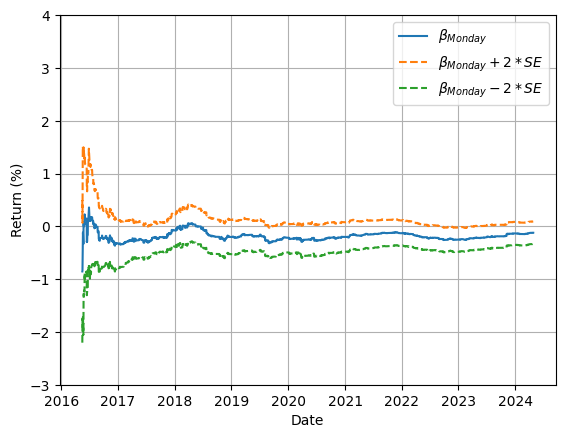

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(parameters['coeff'], label=r'$\beta_{Monday}$')
plt.plot(parameters['Day_of_Week_Monday + 2*se'], label=r'$\beta_{Monday} + 2*SE$', linestyle='dashed')
plt.plot(parameters['Day_of_Week_Monday - 2*se'], label=r'$\beta_{Monday} - 2*SE$', linestyle='dashed')
plt.ylim(-3, 4)
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.legend()
plt.show()